In [1]:
# Load dependencies
import pandas as pd
import numpy as np

import seaborn as sns

# Perform multiple imputation for missing values 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# Train / Test split
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
dfs = pd.read_csv('/Users/Apple/Downloads/All_processed_data/combined_other_datasets_for_modeling.csv')
df = dfs.copy()
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [3]:
df.shape

(1678, 13)

In [4]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB


In [6]:
df['Agec'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['TRICALSc'] = (df['TRICALS'] - df['TRICALS'].mean()) / df['TRICALS'].std()

In [7]:
df_time = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time.describe()
# df_time.isna().sum()

,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,1678.000000,1678.000000,1678.000000
mean,19.616713,5.509496,85.964524
std,12.243001,10.205746,21.991763
min,0.164258,-0.919842,13.873474
25%,12.688896,0.000000,71.584406
50%,17.838371,0.164258,85.627094
75%,24.483715,8.702200,101.000000
max,88.961892,74.310118,158.993367


In [8]:
df['Disease_Durationc'] = np.log1p(df['Disease_Duration'])
df['Diagnostic_Delayc'] = np.log1p(df['Diagnostic_Delay'])
df['Vital_capacityc'] = np.log(df['Vital_capacity'])

In [9]:
print(df.columns)

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt', 'Agec', 'TRICALSc', 'Disease_Durationc',
       'Diagnostic_Delayc', 'Vital_capacityc'],
      dtype='object')


In [10]:
df['European'] = df['European'].astype('int')
df['Event'] = df['Event'].astype('int')

In [11]:
print(df.shape)
df.head(3)

(1678, 18)


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc
0,P01001,0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.251040,-1.068689,3.514542,2.681058,4.672829
1,P01002,1,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.323845,-2.051152,3.750416,3.051071,4.595120
2,P01003,0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-0.975243,-2.069644,3.571548,2.807691,4.624973


In [12]:
df.Event.value_counts()

Event
0    883
1    795
Name: count, dtype: int64

In [13]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Onset_site: {'1.0': 1151, 'Limb': 318, '0.0': 82, 'Bulbar': 77, '2.0': 49, 'Other': 1}

Sex: {'1': 748, '0': 534, 'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Study_Arm: {'ACTIVE': 876, 'PLACEBO': 406, 'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 1649, 2: 9, 3: 8, 4: 7, 0: 4, 5: 1}



In [14]:
mapping = {'Limb': 1, 'Bulbar': 0, 'Other': 1, '1.0': 1,
           '0.0': 0, '2.0': 0, 1.0: 1, 0.0: 0}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 1, 'F': 0, 'Male': 1,'Female': 0, '1': 1, '0': 0}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 1, 1, 0)

In [15]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Onset_site: {1: 1470, 0: 208}

Sex: {1: 1010, 0: 668}

Study_Arm: {'Active': 1075, 'Placebo': 603}

European: {1: 1649, 0: 29}



In [16]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex']  # replace with your actual categorical columns

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [153]:
# df_onehot.head()

In [17]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1'],
      dtype='object')

In [18]:
# Convert one-hot encoded columns to int
df_onehot['Onset_site_1'] = df_onehot['Onset_site_1'].astype(int)
df_onehot['European_1'] = df_onehot['European_1'].astype(int)
df_onehot['Sex_1'] = df_onehot['Sex_1'].astype(int)

In [19]:
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1
0,P01001,0,107.0,Placebo,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.251040,-1.068689,3.514542,2.681058,4.672829,1,1,1
1,P01002,1,99.0,Placebo,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.323845,-2.051152,3.750416,3.051071,4.595120,1,1,0


In [20]:
# Create interactions
df_onehot['Sex_onset_limb'] = df_onehot['Sex_1']*df_onehot['Onset_site_1']
df_onehot['Age_onset_limb'] = df_onehot['Age']*df_onehot['Onset_site_1']
# df_onehot['Age_Riluzole'] = df_onehot['Age']*df_onehot['Riluzole_use_Yes']
# df_onehot['Trical_Study_Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

In [21]:
df_onehot.head(3)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1,Sex_onset_limb,Age_onset_limb
0,P01001,0,107.0,Placebo,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.251040,-1.068689,3.514542,2.681058,4.672829,1,1,1,1,54.762491
1,P01002,1,99.0,Placebo,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.323845,-2.051152,3.750416,3.051071,4.595120,1,1,0,0,61.160849
2,P01003,0,102.0,Active,46.702259,15.571616,34.571616,-6.373852,lica,licals,-0.975243,-2.069644,3.571548,2.807691,4.624973,1,1,1,1,46.702259


In [22]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         1678 non-null   object 
 1   Event              1678 non-null   int64  
 2   Vital_capacity     1678 non-null   float64
 3   Study_Arm          1678 non-null   object 
 4   Age                1678 non-null   float64
 5   Diagnostic_Delay   1678 non-null   float64
 6   Disease_Duration   1678 non-null   float64
 7   TRICALS            1678 non-null   float64
 8   Study_id           1678 non-null   object 
 9   Expt               1678 non-null   object 
 10  Agec               1678 non-null   float64
 11  TRICALSc           1678 non-null   float64
 12  Disease_Durationc  1678 non-null   float64
 13  Diagnostic_Delayc  1678 non-null   float64
 14  Vital_capacityc    1678 non-null   float64
 15  Onset_site_1       1678 non-null   int64  
 16  European_1         1678 

| **Variable Type**             | **Role in Survival Analysis**               | **Data Type in Python**                                      | **Example**                        | **Typical Preprocessing**                                                                  |
| ----------------------------- | ------------------------------------------- | ------------------------------------------------------------ | ---------------------------------- | ------------------------------------------------------------------------------------------ |
| **Time** (duration)           | Time from start point to event or censoring | `int` or `float` (non-negative)                              | `5, 10.2, 7`                       | Ensure numeric, non-negative; convert units if needed                                      |
| **Event Indicator** (status)  | 1 if event occurred, 0 if censored          | `int` (`0/1`) or `bool`                                      | `1, 0, 1, 0`                       | Convert booleans to integers if required by library                                        |
| **Numeric Covariates**        | Continuous predictors                       | `int` or `float`                                             | `age = 65`, `bp = 120`             | Scale/normalize if desired                                                                 |
| **Categorical Covariates**    | Discrete categories                         | `object` or `category`                                       | `sex = 'male', 'female'`           | Convert to dummy variables with `pd.get_dummies()`                                         |
| **Binary Covariates**         | Yes/No predictors                           | `int` (`0/1`) or `bool`                                      | `smoker = 1`                       | Ensure proper encoding (0/1)                                                               |
| **Time-dependent Covariates** | Variables that change over time             | Structured in **long format** with multiple rows per subject | Weight measurements over follow-up | Reshape dataset; specialized survival functions (`add_covariate_to_timeline` in lifelines) |


In [23]:
# df1 = df_onehot[df_onehot['Study_Arm'] == 'Placebo']
df = df_onehot.copy()

## **Survival model**

In [25]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex_onset_limb', 'Age_onset_limb'],
      dtype='object')

In [26]:
df = df[['subject_id', 'Event', 'Vital_capacityc', 'Sex_1', 'Onset_site_1',
       'Study_Arm', 'European_1', 'Diagnostic_Delay', 'Disease_Duration',
        'Study_id', 'Expt', 'Agec', 'TRICALSc', 'Sex_onset_limb', 'Age_onset_limb']]

df = df.rename(columns={'Agec': 'Age',
                        'Vital_capacityc': 'Vital_capacity',
                        'TRICALSc': 'TRICALS',
                        'European_1': 'European',
                        'Onset_site_1': 'Onset_site',
                        'Sex_1': 'Sex'
                        })

In [27]:
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Diagnostic_Delay,Disease_Duration,Study_id,Expt,Age,TRICALS,Sex_onset_limb,Age_onset_limb
0,P01001,0,4.672829,1,1,Placebo,1,13.600526,32.600526,lica,licals,-0.251040,-1.068689,1,54.762491
1,P01002,1,4.595120,0,1,Placebo,1,20.137976,41.538765,lica,licals,0.323845,-2.051152,0,61.160849
2,P01003,0,4.624973,1,1,Active,1,15.571616,34.571616,lica,licals,-0.975243,-2.069644,1,46.702259


In [29]:
print(f"Expt: {df.Expt.value_counts().to_dict()}")
print(f"Study_id: {df.Study_id.value_counts().to_dict()}")

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}
Study_id: {'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}


In [36]:
df216 = df[df['Study_id'] == '216']
df216 = df216.drop(columns=['Study_id', 'subject_id', 'Expt', 'Study_Arm'])

df301 = df[df['Study_id'] == '301']
df301 = df301.drop(columns=['Study_id', 'subject_id', 'Expt', 'Study_Arm'])

df302 = df[df['Study_id'] == '302']
df302 = df302.drop(columns=['Study_id', 'subject_id', 'Expt', 'Study_Arm'])

dfmiro = df[df['Study_id'] == 'miro']
dfmiro = dfmiro.drop(columns=['Study_id', 'subject_id', 'Expt', 'Study_Arm'])

dflica = df[df['Study_id'] == 'lica']
dflica = dflica.drop(columns=['Study_id', 'subject_id', 'Expt', 'Study_Arm'])

dflica.head(3)

,Event,Vital_capacity,Sex,Onset_site,European,Diagnostic_Delay,Disease_Duration,Age,TRICALS,Sex_onset_limb,Age_onset_limb
0,0,4.672829,1,1,1,13.600526,32.600526,-0.251040,-1.068689,1,54.762491
1,1,4.595120,0,1,1,20.137976,41.538765,0.323845,-2.051152,0,61.160849
2,0,4.624973,1,1,1,15.571616,34.571616,-0.975243,-2.069644,1,46.702259


In [37]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import numpy as np
import os


def backward_elimination_cox(df, duration_col="time", event_col="event", p_threshold=0.05):
    """
    Perform backward elimination for a Cox model using p-values.
    Returns fitted model and retained features.
    """
    features = [col for col in df.columns if col not in [duration_col, event_col]]
    df_model = df.copy()

    while True:
        cph = CoxPHFitter()
        cph.fit(df_model, duration_col=duration_col, event_col=event_col)
        pvals = cph.summary["p"]
        max_p = pvals.max()

        if max_p > p_threshold:
            worst_feature = pvals.idxmax()
            df_model = df_model.drop(columns=[worst_feature])
        else:
            break

        # Stop if only duration/event left
        if len(df_model.columns) <= 2:
            break

    final_features = [col for col in df_model.columns if col not in [duration_col, event_col]]
    return cph, final_features


In [38]:
def cross_validate_cox_backward(
    datasets,
    duration_col="time",
    event_col="event",
    p_threshold=0.05,
    output_dir="cox_fold_summaries"
):
    """
    Leave-one-dataset-out CV for Cox model with backward elimination.
    Saves per-fold model summaries as CSVs.

    Parameters
    ----------
    datasets : list of pd.DataFrame
        List of datasets.
    duration_col : str, default='time'
        Column for duration/time.
    event_col : str, default='event'
        Column for event indicator.
    p_threshold : float, default=0.05
        P-value cutoff for backward elimination.
    output_dir : str, default='cox_fold_summaries'
        Directory where fold summaries (CSVs) will be saved.

    Returns
    -------
    results_df : pd.DataFrame
        C-index per fold and mean.
    models : list
        List of fitted CoxPHFitter models.
    features_per_fold : dict
        Mapping of fold -> selected features.
    coef_summary : pd.DataFrame
        Coefficients across folds (NaN where excluded).
    """

    os.makedirs(output_dir, exist_ok=True)

    results = []
    models = []
    features_per_fold = {}
    coef_dfs = []

    for i in range(len(datasets)):
        print(f"\n=== Fold {i+1} ===")
        train_dfs = [df for j, df in enumerate(datasets) if j != i]
        train_df = pd.concat(train_dfs, ignore_index=True)
        test_df = datasets[i]

        # Fit model using backward elimination
        model, selected_features = backward_elimination_cox(
            train_df,
            duration_col=duration_col,
            event_col=event_col,
            p_threshold=p_threshold
        )

        print(f"Selected features (Fold {i+1}): {selected_features}")

        # Evaluate on test set
        test_pred = model.predict_partial_hazard(
            test_df[selected_features + [duration_col, event_col]]
        )
        cindex = concordance_index(
            test_df[duration_col], -test_pred, test_df[event_col]
        )

        results.append({
            "fold": i + 1,
            "concordance_index": cindex
        })
        models.append(model)
        features_per_fold[f"fold_{i+1}"] = selected_features

        # Store coefficient summary
        coef = model.params_.rename(f"fold_{i+1}")
        coef_dfs.append(coef.to_frame())

        # ✅ Save model summary as CSV
        summary_csv_path = os.path.join(output_dir, f"cox_fold_{i+1}_summary.csv")
        model.summary.to_csv(summary_csv_path, index=True)
        print(f"Model summary saved → {summary_csv_path}")

    # Build results table
    results_df = pd.DataFrame(results)
    results_df.loc["Mean"] = ["Mean", results_df["concordance_index"].mean()]

    # Combine coefficients
    coef_summary = pd.concat(coef_dfs, axis=1)
    coef_summary["mean_coef"] = coef_summary.mean(axis=1)
    coef_summary["std_coef"] = coef_summary.std(axis=1)

    return results_df, models, features_per_fold, coef_summary


In [39]:
# Suppose you have 5 datasets: df1, df2, df3, df4, df5
datasets = [df216, df301, df302, dfmiro, dflica]

cv_results, fitted_models, features_per_fold, coef_summary = cross_validate_cox_backward(
    datasets,
    duration_col="Disease_Duration",
    event_col="Event",
    p_threshold=0.05,
    output_dir="cox_models_cv"
)

print("\nCross-validation results:")
print(cv_results)

print("\nSelected features per fold:")
for fold, feats in features_per_fold.items():
    print(f"{fold}: {feats}")

print("\nCoefficient summary:")
print(coef_summary.head())


=== Fold 1 ===
Selected features (Fold 1): ['Vital_capacity', 'Onset_site', 'Diagnostic_Delay', 'TRICALS', 'Age_onset_limb']
Model summary saved → cox_models_cv/cox_fold_1_summary.csv

=== Fold 2 ===
Selected features (Fold 2): ['Vital_capacity', 'Age', 'TRICALS']
Model summary saved → cox_models_cv/cox_fold_2_summary.csv

=== Fold 3 ===
Selected features (Fold 3): ['Vital_capacity', 'Onset_site', 'European', 'Diagnostic_Delay', 'Age', 'TRICALS']
Model summary saved → cox_models_cv/cox_fold_3_summary.csv

=== Fold 4 ===
Selected features (Fold 4): ['Vital_capacity', 'Onset_site', 'Diagnostic_Delay', 'Age', 'TRICALS']
Model summary saved → cox_models_cv/cox_fold_4_summary.csv

=== Fold 5 ===
Selected features (Fold 5): ['Vital_capacity', 'Onset_site', 'Diagnostic_Delay', 'Age', 'TRICALS']
Model summary saved → cox_models_cv/cox_fold_5_summary.csv

Cross-validation results:
      fold  concordance_index
0        1           0.912442
1        2           0.807940
2        3           0.7

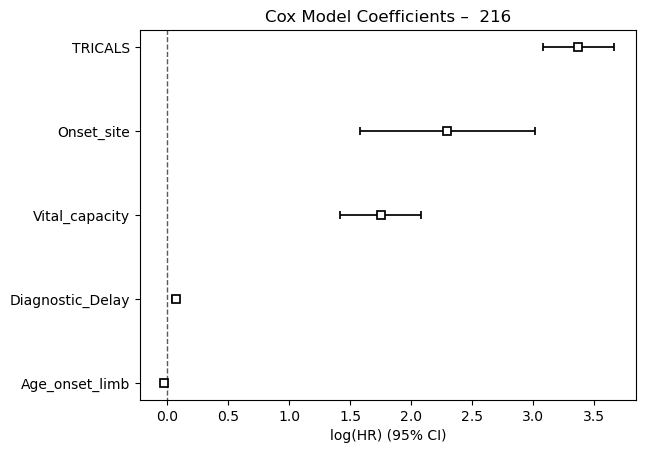

In [46]:
# Pick a fold (e.g., Fold 1)
fold_index = 0  # 0 = first fold
model = fitted_models[fold_index]

# Simple coefficient plot
model.plot()
plt.title(f"Cox Model Coefficients –  216")
plt.show()

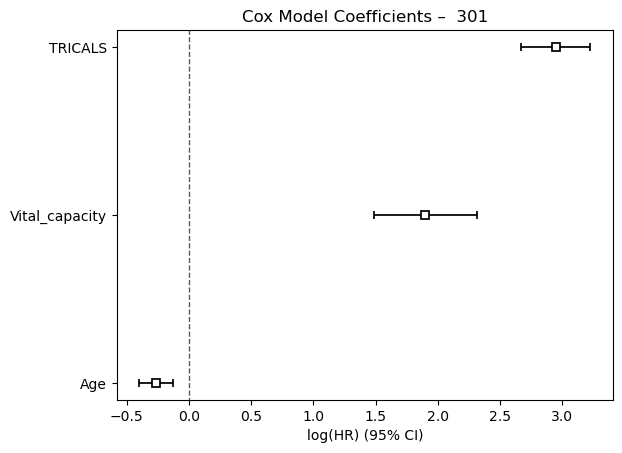

In [47]:
# Pick a fold (e.g., Fold 1)
fold_index = 1  # 0 = first fold
model = fitted_models[fold_index]

# Simple coefficient plot
model.plot()
plt.title(f"Cox Model Coefficients –  301")
plt.show()

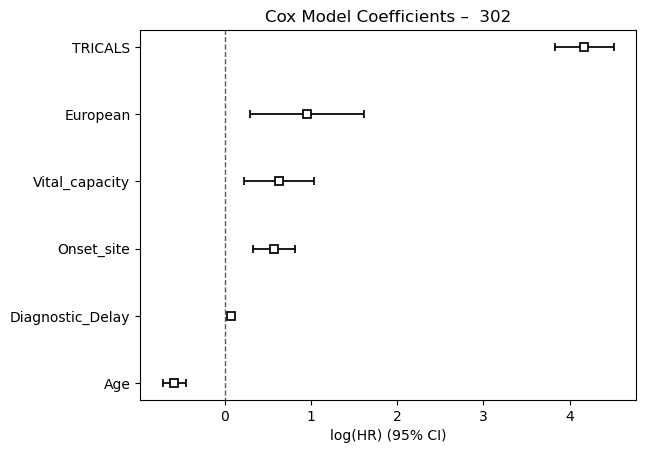

In [48]:
# Pick a fold (e.g., Fold 1)
fold_index = 2  # 0 = first fold
model = fitted_models[fold_index]

# Simple coefficient plot
model.plot()
plt.title(f"Cox Model Coefficients –  302")
plt.show()

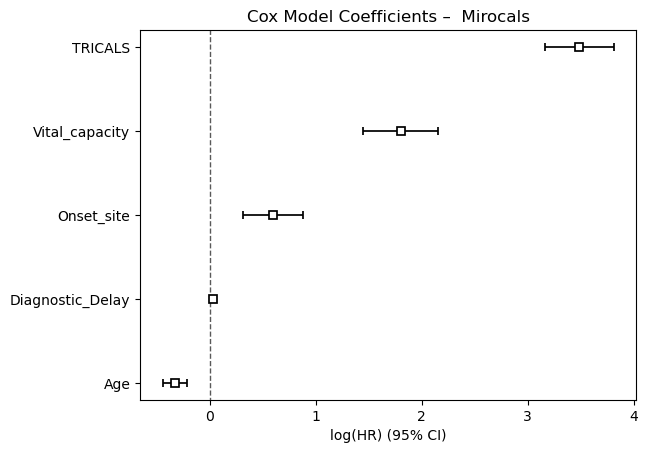

In [49]:
# Pick a fold (e.g., Fold 1)
fold_index = 3  # 0 = first fold
model = fitted_models[fold_index]

# Simple coefficient plot
model.plot()
plt.title(f"Cox Model Coefficients –  Mirocals")
plt.show()

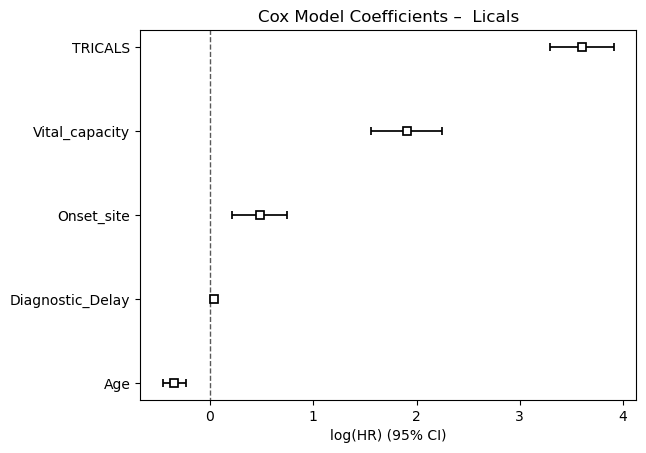

In [50]:
# Pick a fold (e.g., Fold 1)
fold_index = 4  # 0 = first fold
model = fitted_models[fold_index]

# Simple coefficient plot
model.plot()
plt.title(f"Cox Model Coefficients –  Licals")
plt.show()

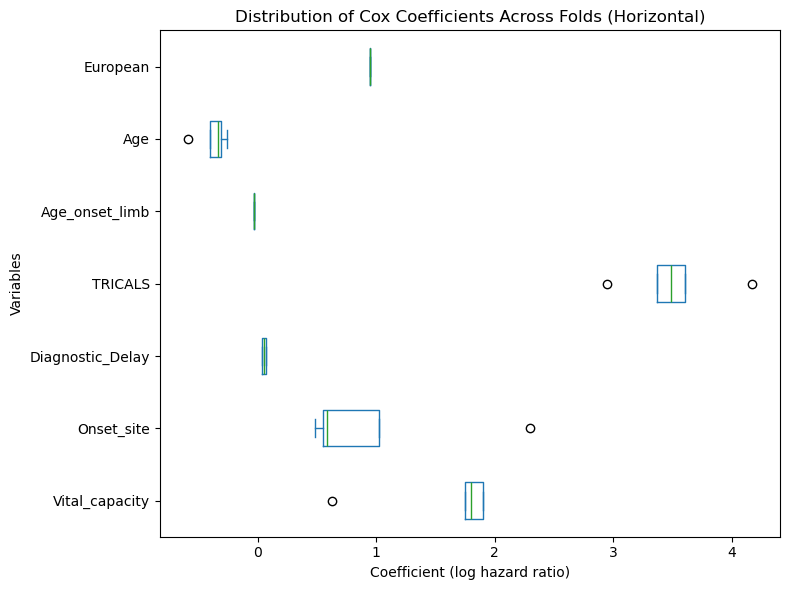

In [51]:
import matplotlib.pyplot as plt

coef_data = coef_summary.drop(columns=["mean_coef", "std_coef"]).T

coef_data.plot(kind="box", vert=False, figsize=(8, 6))
plt.title("Distribution of Cox Coefficients Across Folds (Horizontal)")
plt.xlabel("Coefficient (log hazard ratio)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()